In [10]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
import os.path
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime


# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.preprocessing import quantile_transform

from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from sklearn import datasets

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import SpectralClustering

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

#sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Levanto toda la data

In [2]:
#df_num = pd.read_pickle('../sources/df_merged_all_quantiles_mediana_iqr.pickle')
df_num = pd.read_pickle('../sources/df_merged_posta_preprocesado.pickle')

genre_real = df_num['genre']

df_num = df_num.drop('genre',1)

Selecciono las variables, que son con las que voy a proceder en el resto del trabajo.

Así que empiezo a remover las variables que considero que no me van a ayudar para una apropiada clasificacion que genere algún sentido de explicación

In [3]:
list(df_num.columns)

['af_duration_ms',
 'af_danceability',
 'af_energy',
 'af_loudness',
 'af_speechiness',
 'af_acousticness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'aa_confidence_mediana',
 'aa_loudness_start_mediana',
 'aa_loudness_max_time_mediana',
 'aa_loudness_max_mediana',
 'aa_confidence_iqr',
 'aa_loudness_start_iqr',
 'aa_loudness_max_time_iqr',
 'aa_loudness_max_iqr',
 'aa_loudness_start_dif_mediana',
 'aa_loudness_max_time_dif_mediana',
 'aa_loudness_max_dif_mediana',
 'aa_loudness_start_dif_iqr',
 'aa_loudness_max_time_dif_iqr',
 'aa_loudness_max_dif_iqr',
 'aa_pitch_dif_mediana',
 'aa_pitch_dif_iqr',
 'aa_pitch_mediana',
 'aa_pitch_iqr',
 'aa_timbre_dif_mediana',
 'aa_timbre_dif_iqr',
 'aa_timbre_mediana',
 'aa_timbre_iqr']

Miro cómo quedó la distribución de las variables que voy a analizar.
Todas bien normalizadas.

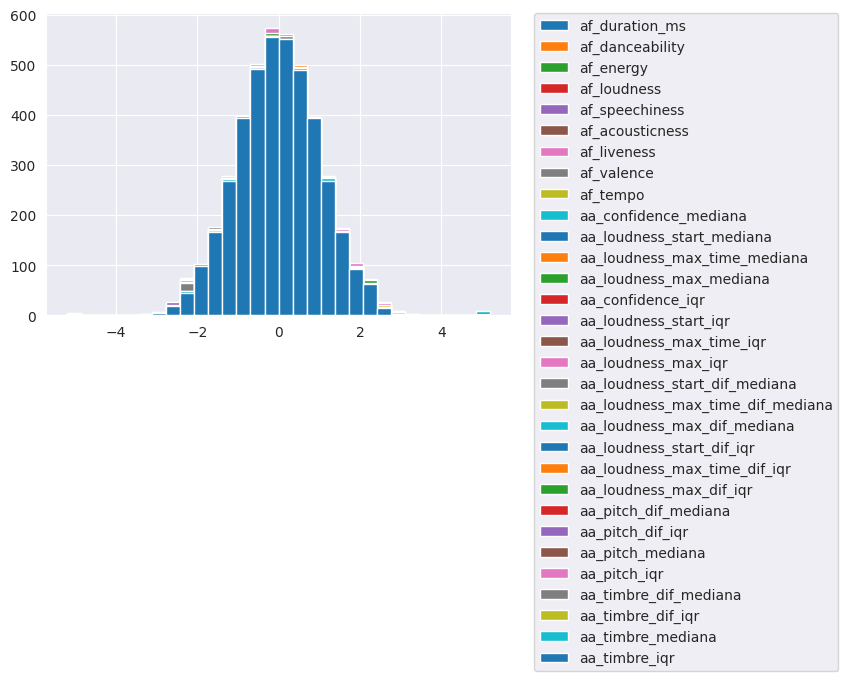

In [4]:
# 
cols = df_num.columns
for k in cols:
    df_num[k].hist(bins=30)
plt.legend(cols,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Y ahora aplico el t-SNE.

In [5]:
tsne = TSNE(n_components=2, perplexity=20, init='pca')
Xred = tsne.fit_transform(df_num)

Y despues grafico para las clases posta

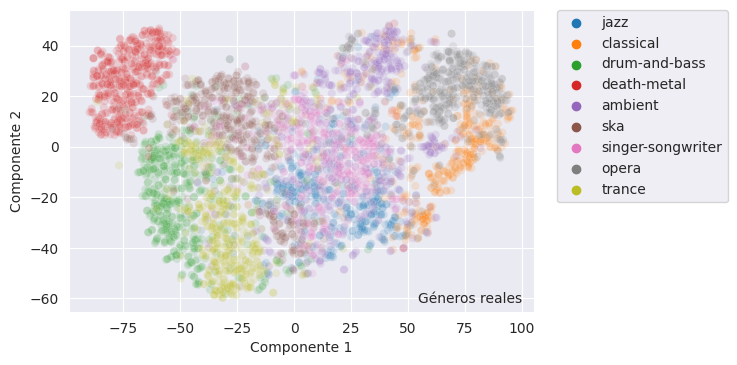

In [6]:
dfff = pd.DataFrame ({"Componente 1":Xred[:,0],"Componente 2":Xred[:,1],"Genero":genre_real.values})
sns.scatterplot(data=dfff, x="Componente 1", y="Componente 2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.text(100, -60,'Géneros reales',
     horizontalalignment='right',
     verticalalignment='center')

plt.savefig('tsne_genero.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# VALIDACION

In [7]:
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics


def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

def validacion(Z2):
    tmp = pd.DataFrame({'Labels': np.array(genre_real), 'Clusters': Z2})# Create a DataFrame with labels and varieties as columns: df
    ct0 = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Create crosstab: ct
    silhouette = metrics.silhouette_score(df_num, Z2)
    print(f'Silhouette Coefficient: {silhouette:.3f}')
    vandon = vanDongen(ct0)
    print(f'Van Dongen score: {vandon:.3f} (optimo 0.0)')
    ari0 = adjusted_rand_score(genre_real, Z2)
    print(f'Adjusted Rand score: {ari0:.3f} (optimo 1.0)')
    return silhouette,vandon,ari0

In [8]:
# VALIDACION CONTRA SIGO MISMA

validacion(genre_real)

Silhouette Coefficient: 0.050
Van Dongen score: 0.000 (optimo 0.0)
Adjusted Rand score: 1.000 (optimo 1.0)


(0.04955886133354917, 0.0, 1.0)

# CLUSTERING - ALTERNATIVAS

In [30]:
len(df_num.columns)
letra = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
n=9

In [14]:
def timestamp_filename(name, ext):
    return name+"_"+datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")+"."+ext

/home/daro/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/lib/python3.8/subprocess.py:844: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


Silhouette Coefficient: 0.108
Van Dongen score: 0.487 (optimo 0.0)
Adjusted Rand score: 0.386 (optimo 1.0)


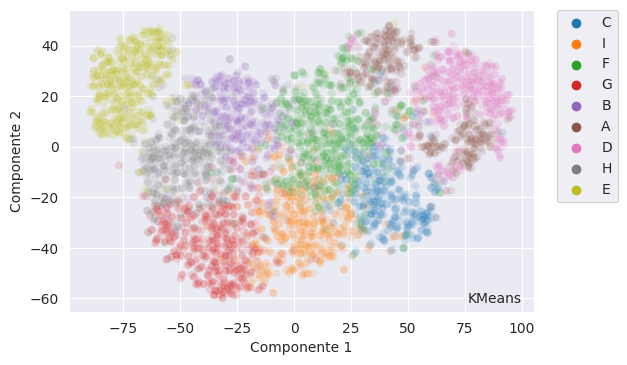

In [31]:

model = KMeans(n_clusters=n, max_iter = 3000, random_state = 0, init='k-means++')

# Convert into PMML format
km_pipeline = PMMLPipeline([("KM", model)])
km_pipeline.fit(df_num)
sklearn2pmml(km_pipeline, timestamp_filename("../pmml/KMeans","pmml"),debug = False)

# Convert into ONNX format
initial_type = [('float_input', FloatTensorType([None, 31]))]
onx = convert_sklearn(model, initial_types=initial_type)
with open(timestamp_filename("../onnx/KMeans","pmml"), "wb") as f:
    f.write(onx.SerializeToString())

Z = km_pipeline.predict(df_num)
Z2 = [letra[x] for x in Z]

validacion(Z2)

dfff = pd.DataFrame ({"Componente 1":Xred[:,0],"Componente 2":Xred[:,1],"Genero":Z2})
sns.scatterplot(data=dfff, x="Componente 1", y="Componente 2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.text(100, -60,'KMeans',
     horizontalalignment='right',
     verticalalignment='center')

plt.savefig('tsne_KMeans.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Y este es el clustering con k meoides. creo q hay bastante q se asocia bien.

Silhouette Coefficient: 0.081
Van Dongen score: 0.590 (optimo 0.0)
Adjusted Rand score: 0.319 (optimo 1.0)


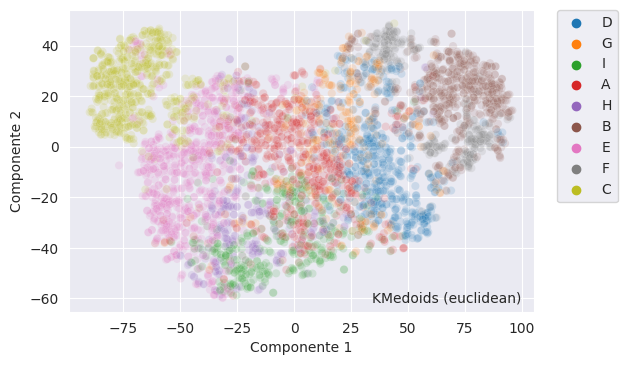

In [22]:
model = KMedoids(metric="euclidean", n_clusters=n, max_iter = 3000, random_state = 0, init='k-medoids++')

model.fit(df_num)
Z = model.predict(df_num)

Z2 = [letra[x] for x in Z]

validacion(Z2)

dfff = pd.DataFrame ({"Componente 1":Xred[:,0],"Componente 2":Xred[:,1],"Genero":Z2})
sns.scatterplot(data=dfff, x="Componente 1", y="Componente 2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.text(100, -60,'KMedoids (euclidean)',
     horizontalalignment='right',
     verticalalignment='center')

plt.savefig('tsne_KMeoids.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Silhouette Coefficient: -0.213
Van Dongen score: 0.933 (optimo 0.0)
Adjusted Rand score: 0.008 (optimo 1.0)


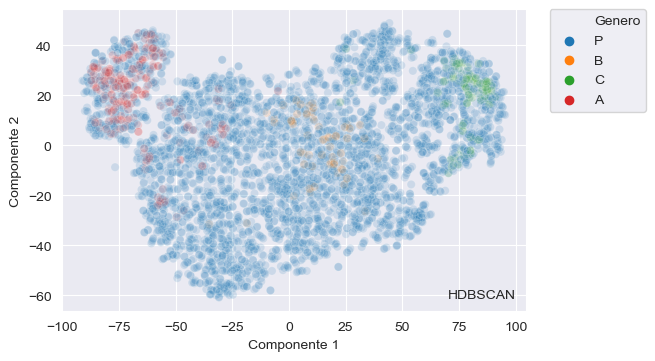

In [14]:
import hdbscan
from sklearn.datasets import make_blobs

clusterer = hdbscan.HDBSCAN(cluster_selection_method='leaf',min_cluster_size=20,alpha=.2,cluster_selection_epsilon=0.1)
Z = clusterer.fit_predict(df_num)
Z2 = [letra[x] for x in Z]

validacion(Z2)


dfff = pd.DataFrame ({"Componente 1":Xred[:,0],"Componente 2":Xred[:,1],"Genero":Z2})
sns.scatterplot(data=dfff, x="Componente 1", y="Componente 2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.text(100, -60,'HDBSCAN',
     horizontalalignment='right',
     verticalalignment='center')

plt.savefig('tsne_HDBSCAN.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Silhouette Coefficient: 0.099
Van Dongen score: 0.562 (optimo 0.0)
Adjusted Rand score: 0.336 (optimo 1.0)


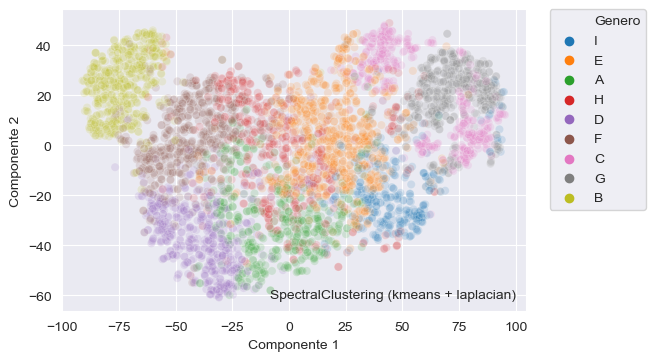

In [15]:
clusterer = SpectralClustering(n_clusters=9,
        assign_labels="kmeans",
        affinity='laplacian',
        gamma=.01,
        n_init=50,
        random_state=0)
Z = clusterer.fit(df_num).labels_
Z2 = [letra[x] for x in Z]

validacion(Z2)

dfff = pd.DataFrame ({"Componente 1":Xred[:,0],"Componente 2":Xred[:,1],"Genero":Z2})
sns.scatterplot(data=dfff, x="Componente 1", y="Componente 2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.text(100, -60,'SpectralClustering (kmeans + laplacian)',
     horizontalalignment='right',
     verticalalignment='center')

plt.savefig('tsne_spectral_kmeans_laplacian.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Silhouette Coefficient: 0.118
Van Dongen score: 0.469 (optimo 0.0)
Adjusted Rand score: 0.377 (optimo 1.0)


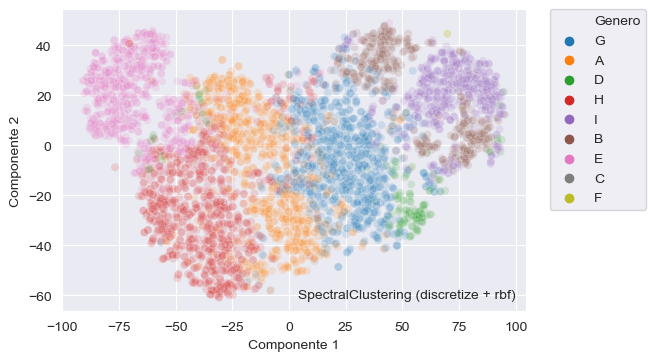

In [16]:
clusterer = SpectralClustering(n_clusters=9,
        assign_labels="discretize",
        affinity='rbf',
        gamma=.06,
        n_init=50,
        random_state=0)
Z = clusterer.fit(df_num).labels_
Z2 = [letra[x] for x in Z]

validacion(Z2)

dfff = pd.DataFrame ({"Componente 1":Xred[:,0],"Componente 2":Xred[:,1],"Genero":Z2})
sns.scatterplot(data=dfff, x="Componente 1", y="Componente 2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.text(100, -60,'SpectralClustering (discretize + rbf)',
     horizontalalignment='right',
     verticalalignment='center')

plt.savefig('tsne_spectral_discrete_rbf.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Silhouette Coefficient: 0.091
Van Dongen score: 0.475 (optimo 0.0)
Adjusted Rand score: 0.385 (optimo 1.0)


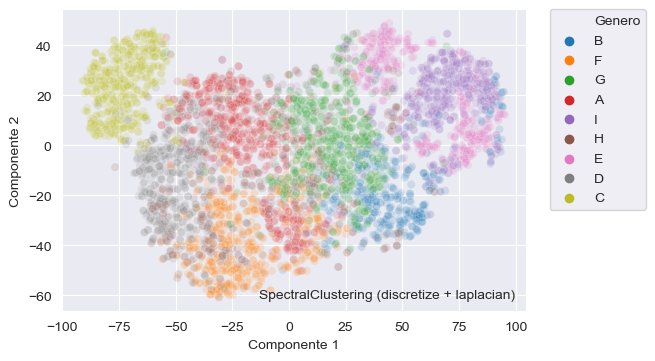

In [17]:
clusterer = SpectralClustering(n_clusters=9,
        assign_labels="discretize",
        affinity='laplacian',
        gamma=.01,
        n_init=50,
        random_state=0)
Z = clusterer.fit(df_num).labels_
Z2 = [letra[x] for x in Z]

validacion(Z2)

dfff = pd.DataFrame ({"Componente 1":Xred[:,0],"Componente 2":Xred[:,1],"Genero":Z2})
sns.scatterplot(data=dfff, x="Componente 1", y="Componente 2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.text(100, -60,'SpectralClustering (discretize + laplacian)',
     horizontalalignment='right',
     verticalalignment='center')

plt.savefig('tsne_spectral_discrete_laplacian.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()